In [1]:
import argparse,logging,os
import mxnet as mx
from symbol_se_resnext_w_d_maxmin import resnext

In [2]:
logger = logging.getLogger()
logger.setLevel(logging.INFO)

formatter = logging.Formatter('%(asctime)s - %(message)s')
console = logging.StreamHandler()
console.setFormatter(formatter)
logger.addHandler(console)

In [3]:
class Options:
    def __init__(self):
        self.gpus = '0,1,2,3' #the gpus will be used, e.g "0,1,2,3"
        self.data_dir = '/tanData/datasets/imagenet/data/imagenet_senet' #the input data directory
        self.data_type = 'imagenet' #the dataset type
        self.depth = 50 #the depth of resnet
        self.batch_size = 192 #the batch size
        self.num_group = 64 #the number of convolution groups
        self.drop_out = 0.0 #the probability of an element to be zeroed
        
        self.list_dir = './' #the directory which contain the training list file
        self.lr = 0.1 #initialization learning rate
        self.mom = 0.9 #momentum for sgd
        self.bn_mom = 0.9 #momentum for batch normlization
        self.wd = 0.0001 #weight decay for sgd
        self.workspace = 512 #memory space size(MB) used in convolution, 
                            #if xpu memory is oom, then you can try smaller vale, such as --workspace 256 
        self.num_classes = 1000 #the class number of your task
        self.aug_level = 2 # level 1: use only random crop and random mirror, 
                           #level 2: add scale/aspect/hsv augmentation based on level 1, 
                           #level 3: add rotation/shear augmentation based on level 2 
        self.num_examples = 1281167 # the number of training examples
        self.kv_store = 'device' # the kvstore type'
        self.model_load_epoch = 0 # load the model on an epoch using the model-load-prefix
        self.frequent = 50 # frequency of logging
        self.memonger = False # true means using memonger to save momory, https://github.com/dmlc/mxnet-memonger
        self.retrain = False # true means continue training
        
args = Options()

In [4]:
hdlr = logging.FileHandler('./log/log-se-resnext-{}-{}.log'.format(args.data_type, args.depth))
hdlr.setFormatter(formatter)
logger.addHandler(hdlr)
logging.info(args)

2018-09-02 06:54:14,787 - <__main__.Options object at 0x7f5734605748>


In [5]:
def multi_factor_scheduler(begin_epoch, epoch_size, step=[30, 60, 90, 95, 110, 120], factor=0.1):
    step_ = [epoch_size * (x-begin_epoch) for x in step if x-begin_epoch > 0]
    return mx.lr_scheduler.MultiFactorScheduler(step=step_, factor=factor) if len(step_) else None

In [6]:
ratio_list = [0.25, 0.125, 0.0625, 0.03125]   # 1/4, 1/8, 1/16, 1/32
if args.data_type == "cifar10":
    args.aug_level = 1
    args.num_classes = 10
    # depth should be one of 110, 164, 1001,...,which is should fit (args.depth-2)%9 == 0
    if((args.depth-2)%9 == 0 and args.depth >= 164):
        per_unit = [(args.depth-2)/9]
        filter_list = [16, 64, 128, 256]
        bottle_neck = True
    elif((args.depth-2)%6 == 0 and args.depth < 164):
        per_unit = [(args.depth-2)/6]
        filter_list = [16, 16, 32, 64]
        bottle_neck = False
    else:
        raise ValueError("no experiments done on detph {}, you can do it youself".format(args.depth))
    units = per_unit*3
    symbol = resnext(units=units, num_stage=3, filter_list=filter_list, ratio_list=ratio_list, num_class=args.num_classes, num_group=args.num_group,
                    data_type="cifar10", drop_out=args.drop_out, bottle_neck = bottle_neck, bn_mom=args.bn_mom, workspace=args.workspace,
                    memonger=args.memonger)
elif args.data_type == "imagenet":
    args.num_classes = 1000
    if args.depth == 18:
        units = [2, 2, 2, 2]
    elif args.depth == 34:
        units = [3, 4, 6, 3]
    elif args.depth == 50:
        units = [3, 4, 6, 3]
    elif args.depth == 101:
        units = [3, 4, 23, 3]
    elif args.depth == 152:
        units = [3, 8, 36, 3]
    elif args.depth == 200:
        units = [3, 24, 36, 3]
    elif args.depth == 269:
        units = [3, 30, 48, 8]
    else:
        raise ValueError("no experiments done on detph {}, you can do it youself".format(args.depth))
    symbol = resnext(units=units, num_stage=4, filter_list=[64, 256, 512, 1024, 2048] if args.depth >=50
                    else [64, 64, 128, 256, 512], ratio_list=ratio_list, num_class=args.num_classes, num_group=args.num_group, data_type="imagenet", drop_out=args.drop_out, bottle_neck = True
                    if args.depth >= 50 else False, bn_mom=args.bn_mom, workspace=args.workspace,
                    memonger=args.memonger)

else:
     raise ValueError("do not support {} yet".format(args.data_type))

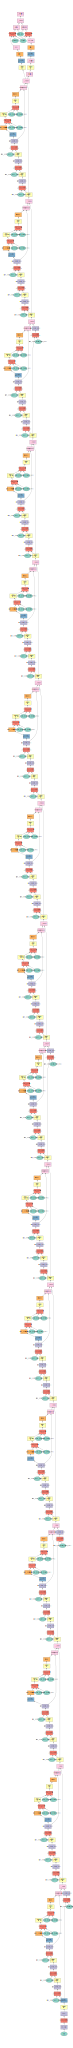

In [7]:
mx.viz.plot_network(symbol)

In [8]:
kv = mx.kvstore.create(args.kv_store)
devs = mx.cpu() if args.gpus is None else [mx.gpu(int(i)) for i in args.gpus.split(',')]
epoch_size = max(int(args.num_examples / args.batch_size / kv.num_workers), 1)
begin_epoch = args.model_load_epoch if args.model_load_epoch else 0
if not os.path.exists("./model"):
    os.mkdir("./model")
model_prefix = "model/se-resnext-{}-{}-{}".format(args.data_type, args.depth, kv.rank)
checkpoint = mx.callback.do_checkpoint(model_prefix)
arg_params = None
aux_params = None
if args.retrain:
    _, arg_params, aux_params = mx.model.load_checkpoint(model_prefix, args.model_load_epoch)
if args.memonger:
    import memonger
    symbol = memonger.search_plan(symbol, data=(args.batch_size, 3, 32, 32) if args.data_type=="cifar10"
                                                else (args.batch_size, 3, 224, 224))

In [9]:
train = mx.io.ImageRecordIter(
    path_imgrec         = os.path.join(args.data_dir, "train.rec") if args.data_type == 'cifar10' else
                          os.path.join(args.data_dir, "train_256_q90.rec") if args.aug_level == 1
                          else os.path.join(args.data_dir, "train_480_q90.rec") ,
    label_width         = 1,
    data_name           = 'data',
    label_name          = 'softmax_label',
    data_shape          = (3, 32, 32) if args.data_type=="cifar10" else (3, 224, 224),
    batch_size          = args.batch_size,
    pad                 = 4 if args.data_type == "cifar10" else 0,
    fill_value          = 127,  # only used when pad is valid
    rand_crop           = True,
    max_random_scale    = 1.0,  # 480 with imagnet, 32 with cifar10
    min_random_scale    = 1.0 if args.data_type == "cifar10" else 1.0 if args.aug_level == 1 else 0.533,  # 256.0/480.0=0.533, 256.0/384.0=0.667 256.0/256=1.0
    max_aspect_ratio    = 0 if args.data_type == "cifar10" else 0 if args.aug_level == 1 else 0.25, # 0.25
    random_h            = 0 if args.data_type == "cifar10" else 0 if args.aug_level == 1 else 36,  # 0.4*90
    random_s            = 0 if args.data_type == "cifar10" else 0 if args.aug_level == 1 else 50,  # 0.4*127
    random_l            = 0 if args.data_type == "cifar10" else 0 if args.aug_level == 1 else 50,  # 0.4*127
    max_rotate_angle    = 0 if args.aug_level <= 2 else 10,
    max_shear_ratio     = 0 if args.aug_level <= 2 else 0.0, #0.1 args.aug_level = 3
    rand_mirror         = True,
    shuffle             = True,
    num_parts           = kv.num_workers,
    part_index          = kv.rank)
val = mx.io.ImageRecordIter(
    path_imgrec         = os.path.join(args.data_dir, "val.rec") if args.data_type == 'cifar10' else
                          os.path.join(args.data_dir, "val_256_q90.rec"),
    label_width         = 1,
    data_name           = 'data',
    label_name          = 'softmax_label',
    batch_size          = args.batch_size,
    data_shape          = (3, 32, 32) if args.data_type=="cifar10" else (3, 224, 224),
    rand_crop           = False,
    rand_mirror         = False,
    num_parts           = kv.num_workers,
    part_index          = kv.rank)

In [10]:
lr_sch = multi_factor_scheduler(begin_epoch, epoch_size, step=[220, 260, 280], factor=0.1) if args.data_type=='cifar10' else multi_factor_scheduler(begin_epoch, epoch_size, step=[30, 60, 90, 95, 110, 120], factor=0.1)
model = mx.mod.Module(
    symbol = symbol,
    context = devs,
    data_names =  ['data'],
    label_names = ['softmax_label']
)
#model.init_params(initializer=mx.init.Xavier(rnd_type='gaussian', factor_type="in", magnitude=2))
#model.init_optimizer(optimizer='nag', optimizer_params={'learning_rate':args.lr, 'momentum':args.mom, 'wd':args.wd, 'lr_scheduler': lr_sch})

In [ ]:
model.fit(
    train_data         = train,
    eval_data          = val,
    eval_metric        = ['acc'] if args.data_type=='cifar10' else
                         ['acc', mx.metric.create('top_k_accuracy', top_k = 5)],
    kvstore            = kv,
    batch_end_callback = mx.callback.Speedometer(args.batch_size, args.frequent),
    epoch_end_callback = checkpoint,
    num_epoch          = 200 if args.data_type == "cifar10" else 125,
    begin_epoch        = begin_epoch,
    arg_params         = arg_params,
    aux_params         = aux_params,
    initializer        = mx.init.Xavier(rnd_type='gaussian', factor_type="in", magnitude=2),
    optimizer          ='nag',
    optimizer_params   ={'learning_rate':args.lr, 'momentum':args.mom, 'wd':args.wd, 'lr_scheduler': lr_sch}
)
# logging.info("top-1 and top-5 acc is {}".format(model.score(X = val,
#               eval_metric = ['acc', mx.metric.create('top_k_accuracy', top_k = 5)])))

2018-09-02 06:54:59,173 - Epoch[0] Batch [50]	Speed: 403.86 samples/sec	accuracy=0.001021	top_k_accuracy_5=0.005208
2018-09-02 06:55:22,913 - Epoch[0] Batch [100]	Speed: 404.61 samples/sec	accuracy=0.001042	top_k_accuracy_5=0.005729
2018-09-02 06:55:46,659 - Epoch[0] Batch [150]	Speed: 404.32 samples/sec	accuracy=0.001146	top_k_accuracy_5=0.004375
2018-09-02 06:56:10,250 - Epoch[0] Batch [200]	Speed: 407.00 samples/sec	accuracy=0.000625	top_k_accuracy_5=0.005417
2018-09-02 06:56:33,849 - Epoch[0] Batch [250]	Speed: 406.86 samples/sec	accuracy=0.001146	top_k_accuracy_5=0.004375
2018-09-02 06:56:57,299 - Epoch[0] Batch [300]	Speed: 409.44 samples/sec	accuracy=0.000833	top_k_accuracy_5=0.005208
2018-09-02 06:57:20,503 - Epoch[0] Batch [350]	Speed: 413.76 samples/sec	accuracy=0.000625	top_k_accuracy_5=0.005208
2018-09-02 06:57:43,753 - Epoch[0] Batch [400]	Speed: 412.96 samples/sec	accuracy=0.000625	top_k_accuracy_5=0.004792
2018-09-02 06:58:06,900 - Epoch[0] Batch [450]	Speed: 414.78 samp